In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
moritzm00_utkface_cropped_path = kagglehub.dataset_download('moritzm00/utkface-cropped')

print('Data source import complete.')


100%|██████████| 116M/116M [00:02<00:00, 41.6MB/s]

Extracting files...


Data source import complete.


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moritzm00/utkface-cropped")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/moritzm00/utkface-cropped/versions/1


In [3]:
import numpy as np
import pandas as pd
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
print(os.listdir("/root/.cache/kagglehub/datasets/moritzm00/utkface-cropped/versions/1/"))

['UTKFace']


In [4]:
def imshow(img):
    plt.imshow(img, interpolation='bicubic')
    plt.xticks([]), plt.yticks([])
    plt.show()

In [5]:
onlyfiles = os.listdir("/root/.cache/kagglehub/datasets/moritzm00/utkface-cropped/versions/1/UTKFace")
y = np.array([[[i.split('_')[0]],[i.split('_')[1]]] for i in onlyfiles])
# y = np.array([[i.split('_')[1] for i in onlyfiles]]).T
print(y.shape)
print(y[0])

(23708, 2, 1)
[['36']
 ['0']]


In [6]:
X_data =[]
for file in onlyfiles:
    face = cv2.imread("/root/.cache/kagglehub/datasets/moritzm00/utkface-cropped/versions/1/UTKFace/"+file,cv2.IMREAD_COLOR)
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face =cv2.resize(face, (32,32) )
    X_data.append(face)
X_data=np.array(X_data)
X_data.shape

(23708, 32, 32, 3)

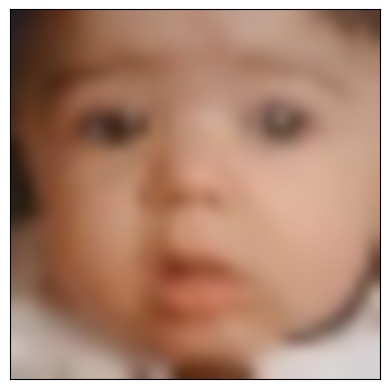

[['1']
 ['0']]


In [8]:
X = np.squeeze(X_data)
imshow(X[1])
print(y[1])

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33)
y_train=[y_train[:,1],y_train[:,0]]
y_valid=[y_valid[:,1],y_valid[:,0]]
print("X_train shape:", X_train.shape)  # (num_samples, 32, 32, 3)
print("y_train shapes:", y_train[0].shape, y_train[1].shape)  # (num_samples,), (num_samples,)
print("X_valid shape:", X_valid.shape)
print("y_valid shapes:", y_valid[0].shape, y_valid[1].shape)


X_train shape: (15884, 32, 32, 3)
y_train shapes: (15884, 1) (15884, 1)
X_valid shape: (7824, 32, 32, 3)
y_valid shapes: (7824, 1) (7824, 1)


In [10]:
y_train = [y_train[0].astype('float32'), y_train[1].astype('float32')]
y_valid = [y_valid[0].astype('float32'), y_valid[1].astype('float32')]


In [11]:
y_gender_train, y_age_train = y_train
y_gender_valid, y_age_valid = y_valid



In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

# 1. Shared feature extractor: ResNet50 (without top layers)
base_model = ResNet50(weights=None, include_top=False, input_shape=(32, 32, 3))

# Use the output of ResNet50 for both tasks
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling

# Shared dense layer
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# 2. Model for Gender Classification (binary classification)
gender_output = Dense(64, activation='relu')(x)
gender_output = Dense(1, activation='sigmoid', name='gender_output')(gender_output)

# 3. Model for Age Prediction (regression)
age_output = Dense(64, activation='relu')(x)
age_output = Dense(1, activation='relu', name='age_output')(age_output)

# 4. Create the Gender Model
gender_model = Model(inputs=base_model.input, outputs=gender_output)

# 5. Create the Age Model
age_model = Model(inputs=base_model.input, outputs=age_output)

# 6. Compile the Models

# Compile the Gender Model (binary classification)
gender_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

# Compile the Age Model (regression)
age_model.compile(optimizer=Adam(), loss=MeanAbsoluteError(), metrics=['mae'])


In [ ]:
import random  # Import the random module

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=75, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs/' + str(random.random()))  # This will now work
]


In [ ]:
import os
import shutil

# Train the Age Model
age_model.fit(X_train, y_train[1], epochs=50, batch_size=240, validation_data=(X_valid, y_valid[1]), callbacks=callbacks, shuffle=True)

# Save the age model
age_model.save('Age_Model_res.keras')

# Define the save directory
save_dir = '/content/models'
os.makedirs(save_dir, exist_ok=True)

# Save the model in the directory
age_model.save(os.path.join(save_dir, 'Age_Model_res.keras'))

# Compress the directory into a zip file for downloading
zip_path = shutil.make_archive(save_dir, 'zip', save_dir)

print(f"Model saved and compressed successfully! Zip file path: {zip_path}")


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 100s 615ms/step - loss: 16.3643 - mae: 16.3643 - val_loss: 23.7975 - val_mae: 23.7975
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - loss: 11.4338 - mae: 11.4338 - val_loss: 14.9981 - val_mae: 14.9981
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 9.9572 - mae: 9.9572 - val_loss: 13.1497 - val_mae: 13.1497
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 8.8405 - mae: 8.8405 - val_loss: 12.8133 - val_mae: 12.8133
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 8.6493 - mae: 8.6493 - val_loss: 14.4707 - val_mae: 14.4707
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 8.4143 - mae: 8.4143 - val_loss: 15.6430 - val_mae: 15.6430
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 8.1206 - mae: 8.1206 - val_loss: 16.6252 - val_mae: 16.6252
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 8.2434 - mae: 8.2434 - val_loss: 14.8553 - val_mae: 14.8553
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━

In [17]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

# 1. Shared feature extractor: ResNet50 (without top layers)
base_model = ResNet50(weights=None, include_top=False, input_shape=(32, 32, 3))

# Use the output of ResNet50 for both tasks
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling

# Shared dense layer
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# 2. Model for Gender Classification (binary classification)
gender_output = Dense(64, activation='relu')(x)
gender_output = Dense(1, activation='sigmoid', name='gender_output')(gender_output)

# 3. Model for Age Prediction (regression)
age_output = Dense(64, activation='relu')(x)
age_output = Dense(1, activation='relu', name='age_output')(age_output)

# 4. Create the Gender Model
gender_model = Model(inputs=base_model.input, outputs=gender_output)

# 5. Create the Age Model
age_model = Model(inputs=base_model.input, outputs=age_output)

# 6. Compile the Models
# Compile the Gender Model (binary classification)
gender_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

# Compile the Age Model (regression)
age_model.compile(optimizer=Adam(), loss=MeanAbsoluteError(), metrics=['mae'])

# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=75, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs/' + str(random.random()))  # This will now work
]

# Train the Age Model and store the history
history = age_model.fit(X_train, y_train[1], epochs=50, batch_size=240, validation_data=(X_valid, y_valid[1]), callbacks=callbacks, shuffle=True)

# Extract the training and validation MAE from the history object
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Plot the cumulative MAE curve
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(train_mae), label='Training MAE (Cumulative)', color='blue', alpha=0.7)
plt.plot(np.cumsum(val_mae), label='Validation MAE (Cumulative)', color='red', alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel('Cumulative MAE')
plt.title('Cumulative MAE Curve during Training')
plt.legend()

# Save the plot as a PNG image
plot_save_path = '/content/cumulative_mae_curve.png'
plt.savefig(plot_save_path)
plt.close()

print(f"Cumulative MAE curve saved at: {plot_save_path}")

# Save the age model
age_model.save('Age_Model_res.keras')

# Define the save directory
save_dir = '/content/models'
os.makedirs(save_dir, exist_ok=True)

# Save the model in the directory
age_model.save(os.path.join(save_dir, 'Age_Model_res.keras'))

# Compress the directory into a zip file for downloading
zip_path = shutil.make_archive(save_dir, 'zip', save_dir)

print(f"Model saved and compressed successfully! Zip file path: {zip_path}")


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 94s 518ms/step - loss: 16.6083 - mae: 16.6083 - val_loss: 27.3162 - val_mae: 27.3162
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 10.6912 - mae: 10.6912 - val_loss: 16.5361 - val_mae: 16.5361
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 9.6295 - mae: 9.6295 - val_loss: 12.5274 - val_mae: 12.5274
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 9.0979 - mae: 9.0979 - val_loss: 13.2899 - val_mae: 13.2899
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 8.4563 - mae: 8.4563 - val_loss: 11.2835 - val_mae: 11.2835
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 8.1386 - mae: 8.1386 - val_loss: 13.6435 - val_mae: 13.6435
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 7.3951 - mae: 7.3951 - val_loss: 14.1242 - val_mae: 14.1242
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 7.5397 - mae: 7.5397 - val_loss: 13.5091 - val_mae: 13.5091
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 6

In [19]:
# Evaluate the Age Model on validation data
age_loss, age_mae = age_model.evaluate(X_valid, y_valid[1], verbose=1)
print("Age Model - Loss (MAE):", age_loss)
print("Age Model - MAE:", age_mae)


245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 9.7636 - mae: 9.7636
Age Model - Loss (MAE): 9.86854362487793
Age Model - MAE: 9.86854362487793


In [13]:
def gen_age_model():
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))
    x = layers.Conv2D(32, 3, activation='relu')(inputs)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPool2D(2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPool2D(2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(84, 3, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(1, activation='relu', name='age_out')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer='Adam', loss='mae', metrics=['mae'])
    return model

In [ ]:
age_model_cnn.fit(X_train, y_age_train, epochs=50, batch_size=240, validation_data=(X_valid, y_age_valid))
# Define the save directory
save_dir = '/kaggle/working/age_model_dir'
os.makedirs(save_dir, exist_ok=True)

# Save the model in the directory
age_model_cnn.save(os.path.join(save_dir, 'Age_Model_Cnn.h5'))

# Compress the directory into a zip file for downloading
zip_path = shutil.make_archive(save_dir, 'zip', save_dir)

print(f"Model saved and compressed successfully! Zip file path: {zip_path}")

In [ ]:
# Select the same example for consistency
# True age label
import numpy as np

# Select an example from the validation set
p_id = 322
imshow(X_valid[p_id])
print("True Age:", y_valid[1][p_id])  # y_valid[1] is for age
image_batch = npimage_batch = np.expand_dims(X_valid[p_id], axis=0)


# Predict using the age model
age_prediction = age_model_cnn.predict(image_batch)

# Display the prediction
print("Predicted Age:", age_prediction[0][0])


In [ ]:
age_loss, age_mae = age_model_cnn.evaluate(X_valid, y_age_valid)
print(f"Age Model - Loss (MAE): {age_loss}, MAE: {age_mae}")


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 23.4380 - mae: 23.4380 - val_loss: 20.5039 - val_mae: 20.5039
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 15.0579 - mae: 15.0579 - val_loss: 16.1386 - val_mae: 16.1386
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 13.4573 - mae: 13.4573 - val_loss: 11.1101 - val_mae: 11.1101
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 11.7567 - mae: 11.7567 - val_loss: 14.1009 - val_mae: 14.1009
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 11.7160 - mae: 11.7160 - val_loss: 9.9020 - val_mae: 9.9020
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 10.4351 - mae: 10.4351 - val_loss: 9.9118 - val_mae: 9.9118
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 10.0981 - mae: 10.0981 - val_loss: 10.3361 - val_mae: 10.3361
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.8000 - mae: 9.8000 - val_loss: 8.8204 - val_mae: 8.8204
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/cumulative_mae_curve.png'

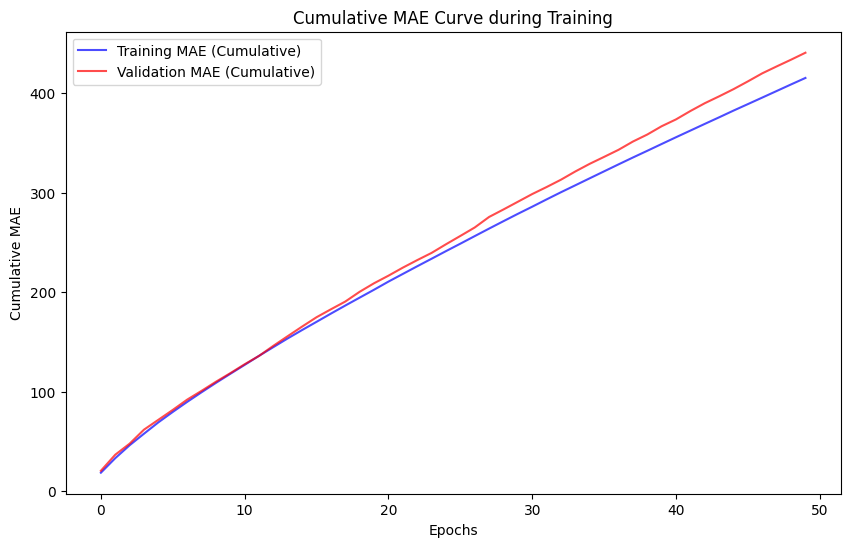

In [15]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

age_model_cnn = gen_age_model()

# Train the model and store the history
history = age_model_cnn.fit(X_train, y_age_train, epochs=50, batch_size=240, validation_data=(X_valid, y_age_valid))

# Extract the training and validation MAE from the history object
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Plot the cumulative MAE curve
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(train_mae), label='Training MAE (Cumulative)', color='blue', alpha=0.7)
plt.plot(np.cumsum(val_mae), label='Validation MAE (Cumulative)', color='red', alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel('Cumulative MAE')
plt.title('Cumulative MAE Curve during Training')
plt.legend()

# Save the plot as a PNG image
plot_save_path = '/kaggle/working/cumulative_mae_curve.png'
plt.savefig(plot_save_path)
plt.close()

print(f"Cumulative MAE curve saved at: {plot_save_path}")

# Define the save directory for the model
save_dir = '/kaggle/working/age_model_dir'
os.makedirs(save_dir, exist_ok=True)

# Save the model in the directory
age_model_cnn.save(os.path.join(save_dir, 'Age_Model_Cnn.h5'))

# Compress the directory into a zip file for downloading
zip_path = shutil.make_archive(save_dir, 'zip', save_dir)

print(f"Model saved and compressed successfully! Zip file path: {zip_path}")

# Select an example from the validation set to predict age for
p_id = 322
imshow(X_valid[p_id])
print("True Age:", y_valid[1][p_id])  # y_valid[1] is for age
image_batch = np.expand_dims(X_valid[p_id], axis=0)

# Predict using the age model
age_prediction = age_model_cnn.predict(image_batch)

# Display the prediction
print("Predicted Age:", age_prediction[0][0])

# Evaluate the model performance on the validation set
age_loss, age_mae = age_model_cnn.evaluate(X_valid, y_age_valid)
print(f"Age Model - Loss (MAE): {age_loss}, MAE: {age_mae}")


In [16]:
plot_save_path = '/content/plots'
plt.savefig(plot_save_path)
plt.close()

In [18]:
age_loss, age_mae = age_model_cnn.evaluate(X_valid, y_age_valid)
print(f"Age Model - Loss (MAE): {age_loss}, MAE: {age_mae}")

245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.9092 - mae: 6.9092
Age Model - Loss (MAE): 7.00347900390625, MAE: 7.00347900390625
